#  Прогнозирование количества заказов такси на следующий час

**Цель проекта** — построить модель предсказания количества заказов такси на следующий час, при этом значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Исходные данные**: файл `taxi.csv`; количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Порядок выполнения проекта:**
1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Введение**

Задача прогнозирования временного ряда состоит в построении модели, которая по историческим данным предскажет будущие значения временного ряда.

Промежуток времени в будущем, на который строится прогноз, называется горизонтом прогнозирования: в проекте горизонт прогнозирования — 1 час.

Значения временного ряда *x(t)* представляют собой количество заказов, т. е. выражены числами, поэтому настоящая задача является задачей регрессии для временных рядов.

## Подготовка

Импортируем необходимые для работы библиотеки и загрузим файл.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col='datetime')
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Параметр `parse_dates` задает имена столбцов, которые будут преобразованы в тип `DateTime` вместо `object`. Кроме того, столбец с датой-временем сразу задаем в виде индекса датасета.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Рассмотрим датасет:
1) он состоит из двух столбцов:
* `datetime` — значение даты и времени на временной оси. Переменная называется так же, как и тип данных datetime. В этой таблице интервал равен 10 минутам, как видно выше.
* `num_orders` — количество заказов за единицу времени (10 минут).

2) Пропущенных значений нет.

3) Размерность данных — 26 496 временн*ы*х значений.

Чтобы проверить, в хронологическом ли порядке расположены даты и время, посмотрим атрибут индекса таблицы `is_monotonic`: если порядок соблюден, атрибут вернет *True*, если нет — *False*.

In [4]:
df.sort_index(inplace=True)
print(df.index.is_monotonic)

True


Построим график временного ряда.

<AxesSubplot:xlabel='datetime'>

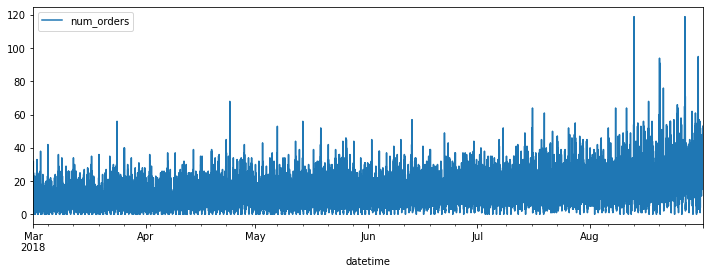

In [5]:
df.plot(figsize=(12,4))

График очень "насыщенный", поскольку очень много значений дат и времени. Также заметны несколько выраженных выбросов.

Проведем ресемплирование — это изменение интервала со значениями ряда. От 10-минутного интервала перейдем к часовому интервалу, усреднив значения по каждому часу. Выбор такого интервала обусловлен постановкой задачи — прогнозом заказов на следующий час.

In [6]:
data = df.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Размерность данных уменьшилась до 4 416 объектов.

## Анализ

Проанализируем полученные после ресемплирования данные. Построим график получившегося датасета.

<AxesSubplot:xlabel='datetime'>

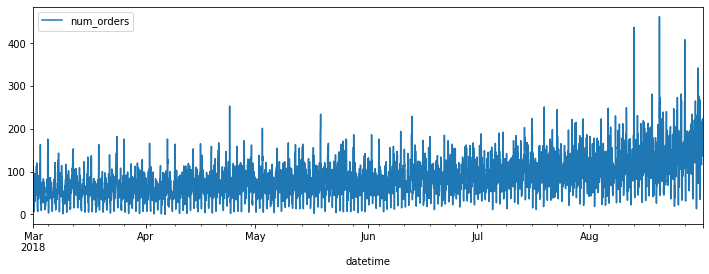

In [7]:
data.plot(figsize=(12,4))

Данные довольно сложно проанализировать из-за большого числа колебаний. Чтобы их снизить, применим скользящее среднее к временному ряду и сразу же найдем СКО по скользящему окну. Размер окна соответствует суточному интервалу (24 часам).

<AxesSubplot:xlabel='datetime'>

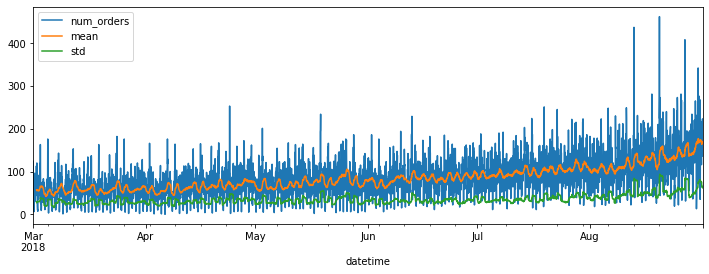

In [8]:
data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()

data.plot(figsize=(12,4))

Рассмотрим один месяц из нашего ряда, например, апрель.

<AxesSubplot:xlabel='datetime'>

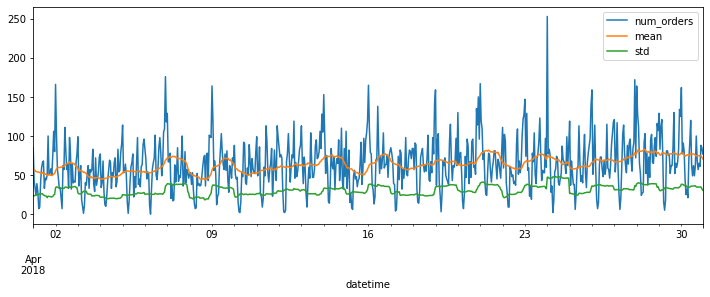

In [9]:
data['2018-04-01' : '2018-04-30'].plot(figsize=(12,4))

На графике выше заметен рост и спад заказов в течение суток. Кроме этого, видны пики, связанные, скорее всего, с днями недели. Так, по ночам заказов меньше, чем днем, а вечером пятницы заказов становится резко больше.

Исследуем сезонность — циклично повторяющиеся закономерности во временном ряду.

In [10]:
decomposed = seasonal_decompose(data['num_orders'])

Функция `seasonal_decompose` раскладывает временной ряд на три составляющие: тренд, сезонность и остаток (шумы).

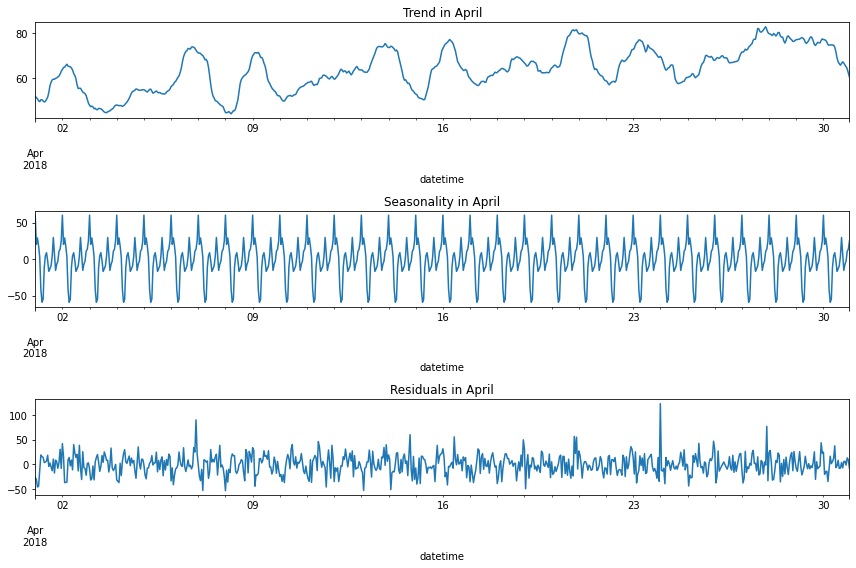

In [11]:
plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend['2018-04-01' : '2018-04-30'].plot(ax=plt.gca())
plt.title('Trend in April')
plt.subplot(312)
decomposed.seasonal['2018-04-01' : '2018-04-30'].plot(ax=plt.gca())
plt.title('Seasonality in April')
plt.subplot(313)
decomposed.resid['2018-04-01' : '2018-04-30'].plot(ax=plt.gca())
plt.title('Residuals in April')
plt.tight_layout()

На первых двух графиках можно увидеть тренд (возрастание значений к концу временного ряда) и цикличность.
Однако временной ряд требует численной проверки на стационарность, помимо визуальной оценки. Для этого проведем обобщенный тест Дикки-Фуллера* на наличие единичных корней с помощью функции adfuller().

[* Ссылка на источник](https://habr.com/ru/post/207160/).

In [12]:
test = adfuller(data['num_orders'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен.')
else:
    print('Единичных корней нет, ряд стационарен.')

adf:  -3.0689242890279558
p-value:  0.028940051402612906
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Единичных корней нет, ряд стационарен.


Ряд стационарен, поэтому больше никаких преобразований с ним выполнять не будем.

## Обучение

### Признаки и выборки

Перейдем к обучению, но для этого вернем датасет в исходный ресэмплированный вид.

In [13]:
data = data.drop(['mean', 'std'], axis=1)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Напишем функцию, которая извлекает признаки из столбца индексов.

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data_mf = data.copy()
    data_mf['year'] = data_mf.index.year
    data_mf['month'] = data_mf.index.month
    data_mf['day'] = data_mf.index.day
    data_mf['dayofweek'] = data_mf.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_mf['lag_{}'.format(lag)] = data_mf['num_orders'].shift(lag)

    data_mf['rolling_mean'] = data_mf['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_mf
    
data_mf = make_features(data, 24, 168)
display(data_mf.head())

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Значение отставания (24 часа) возникло из-за суточной сезонности, а величина скользящего среднего, равная 24х7=168, обусловлена недельной сезонностью.

Из полученного датасета с извлеченными признаками создадим обучающую и тестовую выборки. Размерность тестовой выборки будет составлять 10% от всего набора. Перемешивать выборки в задаче прогнозирования временного ряда нельзя, поэтому параметр `shuffle` равен `False`.

In [16]:
train, test = train_test_split(data_mf, shuffle=False, test_size=0.1)

Проверим, что порядок индексов не нарушился.

In [17]:
print('Индексы обучающей выборки:', train.index.min(), train.index.max())
print('Индексы тестовой выборки:', test.index.min(), test.index.max())

Индексы обучающей выборки: 2018-03-01 00:00:00 2018-08-13 13:00:00
Индексы тестовой выборки: 2018-08-13 14:00:00 2018-08-31 23:00:00


Удалим из обучающей выборки возникшие в результате извлечения признаков пустые значения:

In [18]:
train = train.dropna()

Разделим обе выборки на содержащие признаки и целевой признак и оценим их размерность.

In [19]:
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

In [20]:
print(len(train_features))
print(len(test_features))

3806
442


### LinearRegression

Создадим модель линейной регрессии и обучим ее на обучающей выборке.

In [21]:
model = LinearRegression()

In [22]:
%%time
model.fit(train_features, train_target)

CPU times: user 14.1 ms, sys: 2.12 ms, total: 16.2 ms
Wall time: 6.9 ms


LinearRegression()

Предскажем значения временного ряда на обучающей же выборке и оценим метрику *RMSE*.

In [23]:
%%time
pred_train = model.predict(train_features)
pred_train_df = pd.Series(pred_train, index=train_features.index)

CPU times: user 8.47 ms, sys: 17.1 ms, total: 25.5 ms
Wall time: 16.4 ms


In [24]:
result = mean_squared_error(train_target, pred_train)**0.5
print('RMSE модели на обучающей выборке: {:.2f}.'.format(result))

RMSE модели на обучающей выборке: 25.91.


Модель быстро обучает и предсказывает, значение метрики малое. Однако это не означает, что модель будет выдавать хорошие (точные) результаты на тестовой выборке. Исходных данных у нас не очень много, тестовая выборка тоже одна — зачастую этого недостаточно для проверки качества модели.

### RandomForestRegressor

Применим к обучающей выборке кросс-валидацию. Но для временных рядов необходимо применить метод `TimeSeriesSplit`, чтобы сохранить хронологическую последовательность значений временного ряда в создаваемых в процессе кросс-валидации обучающих и тестовых фолдах.

In [25]:
tscv = TimeSeriesSplit()

Создадим модель случайного леса и подберем для нее гиперпараметры с учетом параметра кросс-валидации.

In [26]:
rfr_model = RandomForestRegressor()

In [27]:
n_estimators = [int(x) for x in np.linspace(start=10, stop=50, num=10)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(start=4, stop=10, num=2)]
parameters_set = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth}

In [28]:
best_forest = RandomizedSearchCV(
    rfr_model,
    parameters_set,
    n_iter = 10,
    n_jobs = -1,
    cv = tscv,
    verbose = 1, 
    random_state=12345)

In [29]:
%%time
best_forest.fit(train_features, train_target)
best_forest.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 4.83 s, sys: 0 ns, total: 4.83 s
Wall time: 4.86 s


{'n_estimators': 23, 'max_features': 'sqrt', 'max_depth': 10}

Предскажем значения на обучающей выборке и оценим метрику.

In [30]:
%%time
rfr_pred_train = best_forest.predict(train_features)
rfr_pred_train_df = pd.Series(rfr_pred_train, index=train_features.index)

CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 13.7 ms


In [31]:
rfr_result = mean_squared_error(train_target, rfr_pred_train)**.5
print('RMSE модели на обучающей выборке: {:.2f}.'.format(rfr_result))

RMSE модели на обучающей выборке: 16.12.


У модели случайного леса метрика *RMSE* на обучающей выборке с учетом кросс-валидации меньше, чем у линейной регрессии, а время обучения на три порядка больше, что довольно предсказуемо.

### CatBoostRegressor

Построим модель градиентного бустинга и также подберем для нее некоторые гиперпараметры.

In [32]:
cbr_model = CatBoostRegressor(learning_rate = 0.2)

In [33]:
n_estimators_cbr = [int(x) for x in np.linspace(start=10, stop=50, num=10)]
max_depth_cbr = [int(x) for x in np.linspace(start=4, stop=10, num=2)]
cbr_parameters_set = {
    'n_estimators': n_estimators_cbr,
    'max_depth': max_depth_cbr}

In [34]:
best_cbr = RandomizedSearchCV(
    cbr_model,
    cbr_parameters_set,
    n_iter = 10,
    n_jobs = -1,
    cv = tscv,
    verbose = 1, 
    random_state=12345)

In [35]:
%%time
best_cbr.fit(train_features, train_target, verbose=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 30.9 s, sys: 0 ns, total: 30.9 s
Wall time: 1min 6s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f35102c6ac0>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [4, 10],
                                        'n_estimators': [10, 14, 18, 23, 27, 32,
                                                         36, 41, 45, 50]},
                   random_state=12345, verbose=1)

In [36]:
%%time
cbr_pred_train = best_cbr.predict(train_features)
cbr_pred_train_df = pd.Series(cbr_pred_train, index=train_features.index)

CPU times: user 4.51 ms, sys: 0 ns, total: 4.51 ms
Wall time: 4.88 ms


In [37]:
cbr_result = mean_squared_error(train_target, cbr_pred_train)**.5
print('RMSE модели на обучающей выборке: {:.2f}.'.format(cbr_result))

RMSE модели на обучающей выборке: 22.97.


У модели бустинга метрика RMSE на обучающей выборке с учетом кросс-валидации — средняя по сравнению с двумя более простыми моделями, а время обучения выше - практически целая минута!

## Тестирование

Сделаем прогноз значений временного ряда и оценим метрику *RMSE* для трех моделей на тестовой выборке.

**Для модели линейной регрессии:**

In [38]:
pred_test = model.predict(test_features)
pred_test_df = pd.Series(pred_test, index=test_features.index)

result_test = mean_squared_error(test_target, pred_test)**.5
print('RMSE модели на тестовой выборке: {:.2f}.'.format(result_test))

RMSE модели на тестовой выборке: 45.23.


Построим график предсказаний на обучающей и тестовой выборках для последней недели временного ряда.

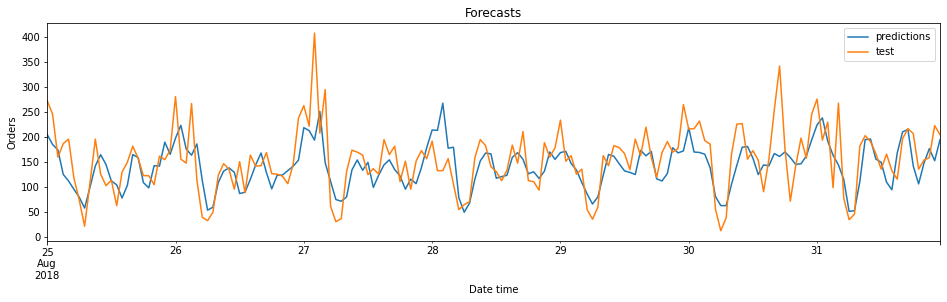

In [39]:
pred_test_df['2018-08-25' : '2018-08-31'].plot(label='predictions', figsize=(16,4))
pd.Series(test_target, index=test_features.index)['2018-08-25' : '2018-08-31'].plot(label='test')
plt.xlabel('Date time')
plt.ylabel('Orders')
plt.title('Forecasts')
plt.legend()
plt.show()

**Для модели случайного леса:**

In [40]:
rfr_pred_test = best_forest.predict(test_features)
rfr_pred_test_df = pd.Series(rfr_pred_test, index=test_features.index)

rfr_result_test = mean_squared_error(test_target, rfr_pred_test)**.5
print('RMSE модели на тестовой выборке: {:.2f}.'.format(rfr_result_test))

RMSE модели на тестовой выборке: 45.23.


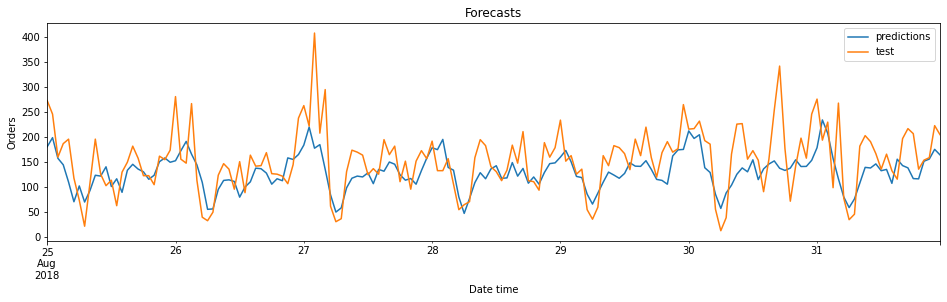

In [41]:
rfr_pred_test_df['2018-08-25' : '2018-08-31'].plot(label='predictions', figsize=(16,4))
pd.Series(test_target, index=test_features.index)['2018-08-25' : '2018-08-31'].plot(label='test')
plt.xlabel('Date time')
plt.ylabel('Orders')
plt.title('Forecasts')
plt.legend()
plt.show()

**Для модели бустинга:**

In [42]:
cbr_pred_test = best_cbr.predict(test_features)
cbr_pred_test_df = pd.Series(cbr_pred_test, index=test_features.index)

cbr_result_test = mean_squared_error(test_target, cbr_pred_test)**.5
print('RMSE модели на обучающей выборке: {:.2f}.'.format(cbr_result_test))

RMSE модели на обучающей выборке: 44.80.


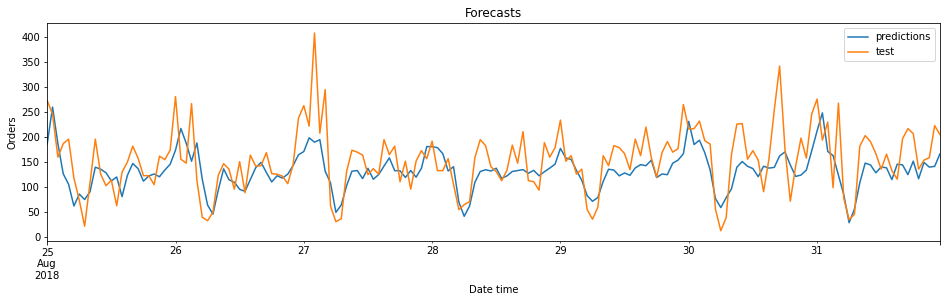

In [43]:
cbr_pred_test_df['2018-08-25' : '2018-08-31'].plot(label='predictions', figsize=(16,4))
pd.Series(test_target, index=test_features.index)['2018-08-25' : '2018-08-31'].plot(label='test')
plt.xlabel('Date time')
plt.ylabel('Orders')
plt.title('Forecasts')
plt.legend()
plt.show()

**Выводы**

* Разработаны 3 модели машинного обучения для прогноза значений временного ряда:
    * линейной регрессии;
    * случайного леса;
    * градиентного бустинга (библиотека *CatBoost*).
* Модели сопоставимы по качеству, но простые модели обучают быстрее, чем модель бустинга.
* Значения метрики *RMSE* на тестовой выборке у всех трех моделей < 46.